# I. Importing the required libraries

In [29]:
# Orignial Notebook: https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer/blob/master/final_results_gender_test.ipynb
# This notebook author: Reza Chu
# Last Editing Date: 31st May 2019

## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

# II. Reading the data

In [30]:
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'actor', 'gender',
                                'emotion'])
count = 0
file_list=os.listdir("C:/EmmotionCorrelation-master/ItalianData")
for f in file_list:
        nm = f.split('.')[0].split('-')
        path =  f
        actor = nm[1]
        emotion = nm[0]
        statement=nm[2]
        
        if actor[0] == 'f':
            gender = "female"
        else:
            gender = "male"
        
        
        
        data_df.loc[count] = [path,actor,gender,emotion]
        count += 1

In [94]:
print (len(data_df))
data_df
data_df[data_df.emotion=='gio']

510


,path,actor,gender,emotion,label
84,gio-f1-b1.wav,f1,female,gio,female_happy
85,gio-f1-b2.wav,f1,female,gio,female_happy
86,gio-f1-b3.wav,f1,female,gio,female_happy
87,gio-f1-d1.wav,f1,female,gio,female_happy
88,gio-f1-d2.wav,f1,female,gio,female_happy
...,...,...,...,...,...
155,gio-m3-b2.wav,m3,male,gio,male_happy
156,gio-m3-b3.wav,m3,male,gio,male_happy
157,gio-m3-d1.wav,m3,male,gio,male_happy
158,gio-m3-d2.wav,m3,male,gio,male_happy


# III. Plotting the audio file's waveform and its spectrogram

In [141]:
filename = data_df.path[155]
print (filename)

samples, sample_rate = librosa.load("C:/EmmotionCorrelation-master/ItalianData"+"/"+data_df.path[155])
sample_rate, samples

gio-m3-b2.wav


(22050,
 array([-1.05034975e-04, -7.61996707e-05, -8.97500504e-05, ...,
        -3.82337777e-04, -2.50916259e-04,  0.00000000e+00], dtype=float32))

In [142]:
len(samples), sample_rate

(53626, 22050)

In [143]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [144]:
sample_rate/ len(samples)

0.41118114347518

In [145]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)




In [146]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [147]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-0.00030473, -0.00013297, -0.00032684, ..., -0.00050724,
        -0.00025859,  0.00117984], dtype=float32),
 array([ 6656, 43008]))

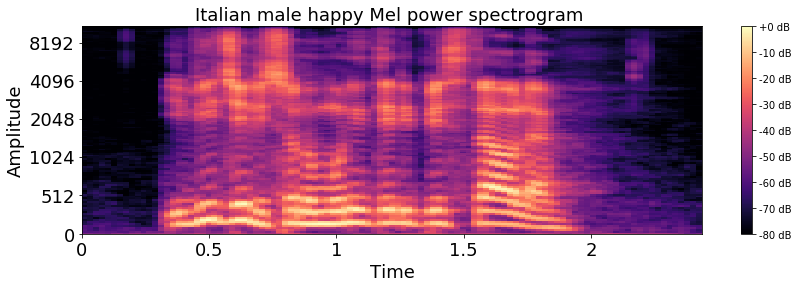

In [186]:
# Plotting Mel Power Spectrogram

S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.

log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12, 4))
ax=librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Italian male happy Mel power spectrogram ',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
ax.set_ylabel('Amplitude',fontsize=18)
ax.set_xlabel('Time',fontsize=18)

plt.savefig('Italian male  happy mel power spectogram')


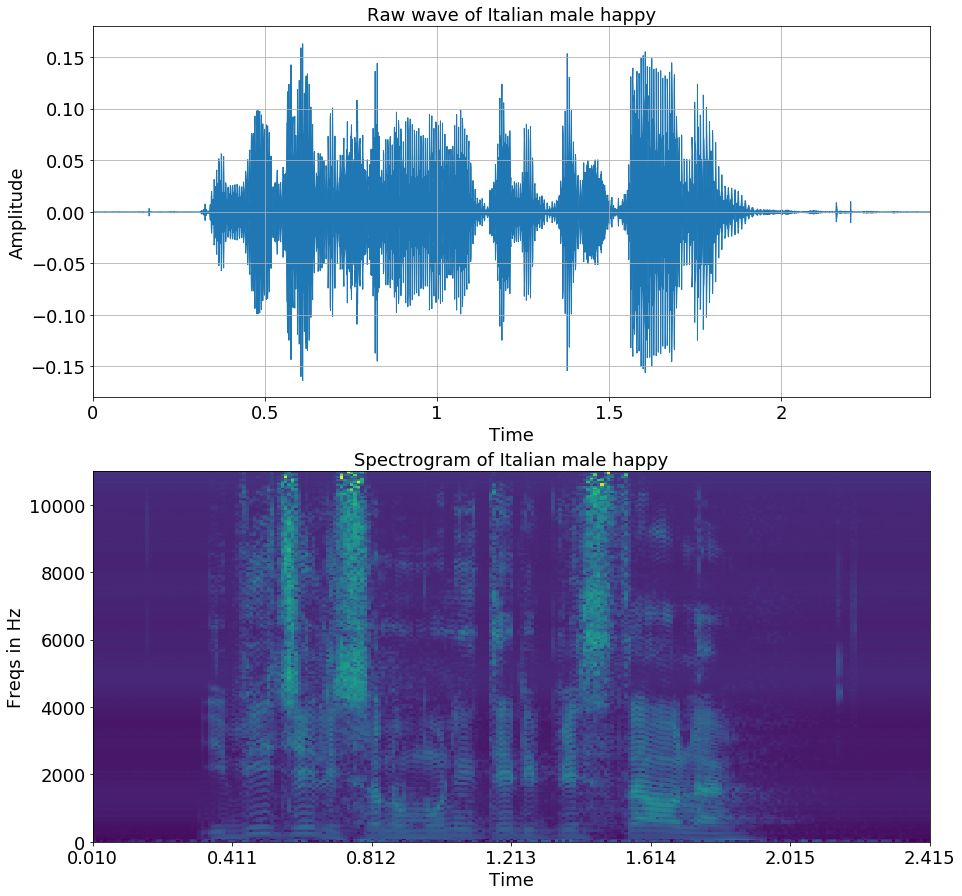

In [187]:
fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + 'Italian male happy',fontsize=18)
ax1.set_ylabel('Amplitude',fontsize=18)
ax1.set_xlabel('Time',fontsize=18)
ax1.grid(True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::40])
plt.xticks(fontsize=18)
ax2.set_xticks(times[::40])
plt.yticks(fontsize=18)
ax2.set_title('Spectrogram of ' + 'Italian male happy',fontsize=18)
ax2.set_ylabel('Freqs in Hz',fontsize=18)
ax2.set_xlabel('Time',fontsize=18)


plt.savefig('Italian happy male spectogram and raw')

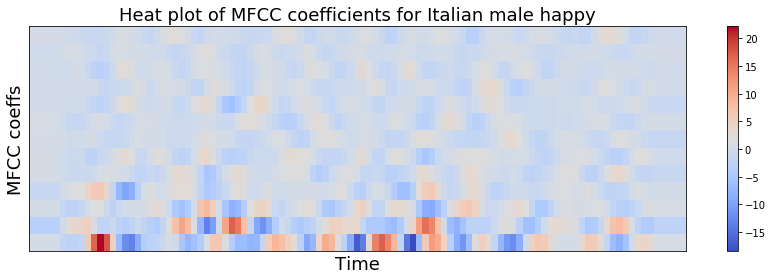

In [185]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs',fontsize=18)
plt.xlabel('Time',fontsize=18)
plt.title('Heat plot of MFCC coefficients for Italian male happy',fontsize=18)
plt.colorbar()
plt.tight_layout()
plt.savefig('Italian male happy heat plot')

In [41]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [42]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [43]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

# IV. Defining the truth label

In [44]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 'C': # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 'J': # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 'T': # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 'C': # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 'P': # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

510

In [45]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

510

In [46]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 'neu':
        lb = "_calm"
    elif data_df.emotion[i] == 'gio':
        lb = "_happy"
    elif data_df.emotion[i] == 'tri':
        lb = "_sad"
    elif data_df.emotion[i] == 'rab':
        lb = "_angry"
    elif data_df.emotion[i] == 'pau':
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

510

In [47]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

510

In [48]:
# Select the label set you want by commenting the unwanteds.

#data_df['label'] = label2_list
# data_df['label'] = label3_list
data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

,path,actor,gender,emotion,label
0,dis-f1-b1.wav,f1,female,dis,female_none
1,dis-f1-b2.wav,f1,female,dis,female_none
2,dis-f1-b3.wav,f1,female,dis,female_none
3,dis-f1-d1.wav,f1,female,dis,female_none
4,dis-f1-d2.wav,f1,female,dis,female_none


In [49]:
print (data_df.label.value_counts().keys())

Index(['female_none', 'male_none', 'female_angry', 'female_calm', 'female_sad',
       'female_happy', 'female_fearful', 'male_happy', 'male_fearful',
       'male_angry', 'male_calm', 'male_sad'],
      dtype='object')


In [50]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

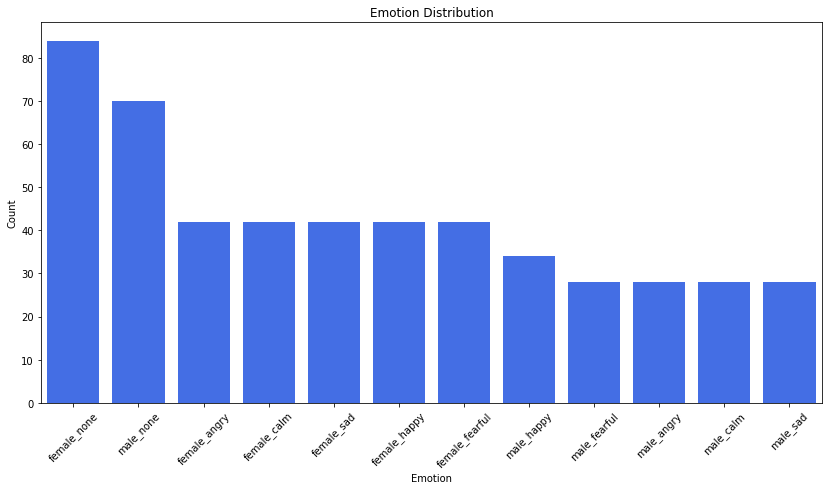

In [51]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

# V. Data Splitting

In [52]:
# Female Data Set

## Uncomment all below to use Female set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"]
# data2_df = data2_df[data2_df.label != "male_happy"]
# data2_df = data2_df[data2_df.label != "male_angry"]
# data2_df = data2_df[data2_df.label != "male_sad"]
data2_df = data2_df[data2_df.label != "male_fearful"]
#data2_df = data2_df[data2_df.label != "male_calm"]
data2_df = data2_df[data2_df.label != "male_positive"]
data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

# tmp1 = data2_df[data2_df.actor == 22]
# tmp2 = data2_df[data2_df.actor == 24]
# data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
# data2_df = data2_df[data2_df.actor != 22]
# data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
# print (len(data2_df))
# data2_df.head()

In [53]:
# Male Data Set

## Uncomment all below to use Male set 

#data2_df = data_df.copy()
#data2_df = data2_df[data2_df.label != "male_none"]
#data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
#data2_df = data2_df[data2_df.label != "female_neutral"]
#data2_df = data2_df[data2_df.label != "female_happy"]
#data2_df = data2_df[data2_df.label != "female_angry"]
#data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
#data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

#tmp1 = data2_df[data2_df.actor == 21]
#tmp2 = data2_df[data2_df.actor == 22]
#tmp3 = data2_df[data2_df.actor == 23]
#tmp4 = data2_df[data2_df.actor == 24]
#data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
#data2_df = data2_df[data2_df.actor != 21]
#data2_df = data2_df[data2_df.actor != 22]
#data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
#data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
#print (len(data2_df))
#data2_df.head()

286


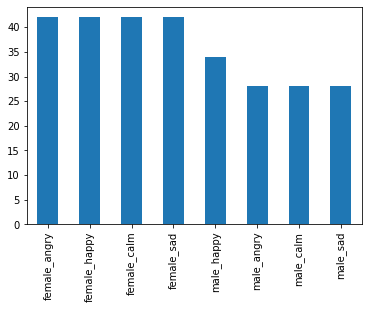

In [54]:
print (len(data2_df))
data2_df.label.value_counts().plot(kind='bar')

# VI. Getting the features of audio files using librosa

In [55]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load("C:/EmmotionCorrelation-master/ItalianData"+"/"+data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=11025,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|████████████████████████████████████████████████████████████████████████████████| 286/286 [00:09<00:00, 30.16it/s]


In [88]:
librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

array([[-4.02958188e+02, -4.07607192e+02, -4.44430482e+02,
        -5.03573477e+02, -4.97049201e+02, -4.17475329e+02,
        -3.44740377e+02, -3.16340911e+02, -3.29918557e+02,
        -3.69725686e+02, -4.01228985e+02, -3.28880434e+02,
        -3.14806845e+02, -3.56034904e+02, -3.27448200e+02,
        -2.99511088e+02, -3.21239226e+02, -3.81998941e+02,
        -4.36267019e+02, -4.72609279e+02, -5.15275931e+02,
        -5.90336426e+02, -6.47084932e+02, -5.96426920e+02,
        -4.83898638e+02, -4.14174543e+02, -3.75844811e+02,
        -3.73759600e+02, -3.72043734e+02, -3.54395031e+02,
        -3.69585234e+02, -3.93114644e+02, -3.90826002e+02,
        -3.93618651e+02, -4.40987949e+02, -4.48835809e+02,
        -4.19939222e+02, -4.31608352e+02, -4.13249424e+02,
        -3.93078941e+02, -4.04595223e+02, -3.89046647e+02,
        -3.85148345e+02, -3.83932290e+02, -3.49265187e+02,
        -3.48416910e+02, -4.10308650e+02, -4.06797328e+02,
        -3.44325140e+02, -3.27188320e+02, -3.72595063e+0

In [56]:
data.head()

,feature
0,"[-12.958726769975224, -8.960438062575225, -10...."
1,"[-17.19638977194051, -18.81715702104432, -20.6..."
2,"[-15.532285695812288, -15.94016722433807, -19...."
3,"[-41.20396225139336, -40.67065049001003, -33.0..."
4,"[-40.13850096576265, -21.775403307746544, -10...."


In [57]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [58]:
newdf = pd.concat([df3,labels], axis=1)

In [59]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

286

In [60]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-12.958727,-8.960438,-10.585801,-20.048144,-23.720495,-27.356837,-25.590474,-23.891646,-21.239610,-17.473833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_happy
1,-17.196390,-18.817157,-20.658501,-20.354739,-18.558330,-22.859265,-27.986143,-28.161847,-27.824130,-28.110926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_happy
2,-15.532286,-15.940167,-19.426382,-18.439185,-16.738193,-20.177370,-21.678285,-23.661842,-27.336681,-31.445938,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_happy
3,-41.203962,-40.670650,-33.072638,-25.494408,-26.686402,-23.083997,-20.470415,-22.859257,-23.496542,-18.668210,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_happy
4,-40.138501,-21.775403,-10.196636,-8.223827,-13.843441,-15.795876,-12.154737,-11.946839,-18.834485,-22.502770,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_happy
5,-41.687115,-39.368303,-35.567128,-27.641951,-24.806846,-18.709392,-16.546106,-13.892077,-12.520183,-14.915337,...,-38.305502,-40.016753,-40.356381,-39.984662,-38.991030,-39.019313,-37.995499,-38.223183,-39.534811,female_happy
6,-9.148806,-13.541585,-17.348069,-19.331611,-23.344809,-23.699110,-23.359050,-21.835090,-19.844886,-19.663015,...,-33.397062,-38.235616,-38.422890,-38.852463,-40.131221,-40.827847,-41.344511,-41.339346,-41.338167,female_happy
7,-9.446641,-5.981226,-7.798957,-15.256304,-22.365819,-17.732518,-12.125295,-15.499719,-26.753060,-26.777847,...,-29.660749,-30.364210,-24.139675,-19.333507,-19.938888,-18.771012,-19.050314,-21.617239,-19.828556,female_happy
8,-1.487351,-2.862927,-9.199150,-14.175071,-17.341526,-22.647886,-24.914798,-26.844218,-29.748897,-31.877948,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_happy
9,-24.183641,-18.220293,-16.944195,-22.690258,-24.306568,-25.133141,-21.848796,-20.420802,-14.829581,-15.593348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,female_happy


In [61]:
rnewdf.isnull().sum().sum()

4885

In [62]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-12.958727,-8.960438,-10.585801,-20.048144,-23.720495,-27.356837,-25.590474,-23.891646,-21.239610,-17.473833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female_happy
1,-17.196390,-18.817157,-20.658501,-20.354739,-18.558330,-22.859265,-27.986143,-28.161847,-27.824130,-28.110926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female_happy
2,-15.532286,-15.940167,-19.426382,-18.439185,-16.738193,-20.177370,-21.678285,-23.661842,-27.336681,-31.445938,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female_happy
3,-41.203962,-40.670650,-33.072638,-25.494408,-26.686402,-23.083997,-20.470415,-22.859257,-23.496542,-18.668210,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female_happy
4,-40.138501,-21.775403,-10.196636,-8.223827,-13.843441,-15.795876,-12.154737,-11.946839,-18.834485,-22.502770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female_happy


# VII. Data Augmentation

In [73]:
def plot_time_series(data,color='blue'):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data,color=color)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data






In [64]:
def plot_time_series1(data,data1,color='blue',color1='green',label1='',label2=''):
    """
    Plot the Audio Frequency.
    """
    data , bb = librosa.effects.trim(data, top_db=30)
    data1 , bb1 = librosa.effects.trim(data1, top_db=30)
    
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data,color=color,alpha=0.5,label=label1)
    plt.plot(np.linspace(0, 1, len(data1)),data1,color=color1,alpha=0.4,label=label2)
    plt.legend(loc='upper left',framealpha=0.4)
    plt.grid(True)
    plt.axis('tight')
    

In [71]:
def plot_time_series2(data,data1,color='blue',color1='green',label1='',label2=''):
    """
    Plot the Audio Frequency.
    """
    
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data,color=color,alpha=0.5,label=label1)
    plt.plot(np.linspace(0, 1, len(data1)),data1,color=color1,alpha=0.4,label=label2)
    plt.legend(loc='upper left',framealpha=0.4)
    plt.grid(True)
    plt.axis('tight')
    

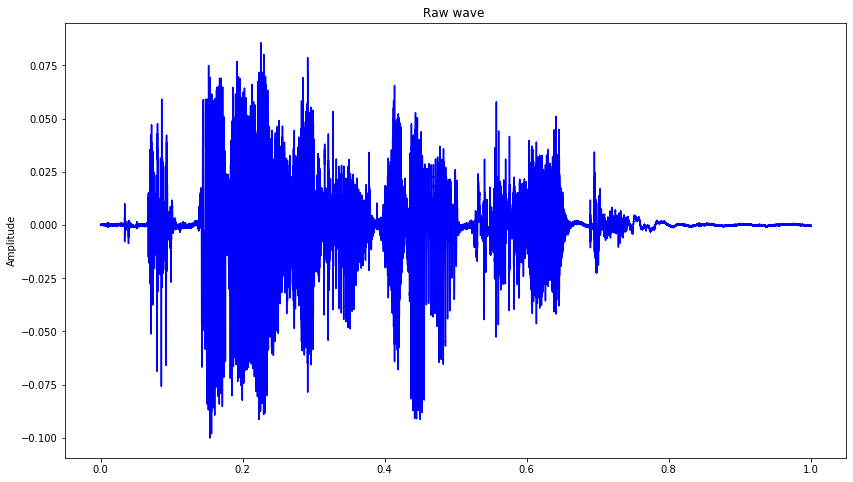

In [65]:
orig, sample_rate = librosa.load("C:/EmmotionCorrelation-master/ItalianData"+"/"+data2_df.path[216], res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
plot_time_series(orig)
ipd.Audio(orig, rate=sample_rate)

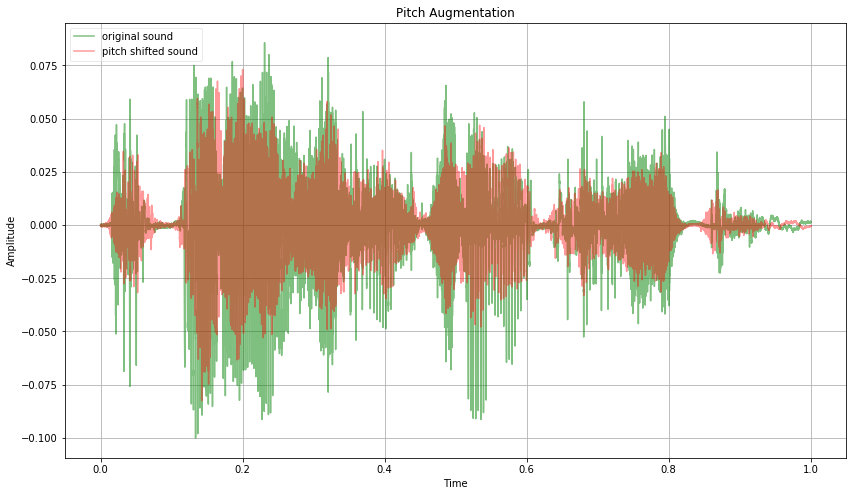

In [80]:
padjust = pitch(orig,sample_rate)
plot_time_series1(orig,padjust,color="green",color1='red',label1='original sound',label2='pitch shifted sound')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Pitch Augmentation')

plt.savefig('Pitch Augmentation1')
ipd.Audio(padjust, rate=sample_rate)  


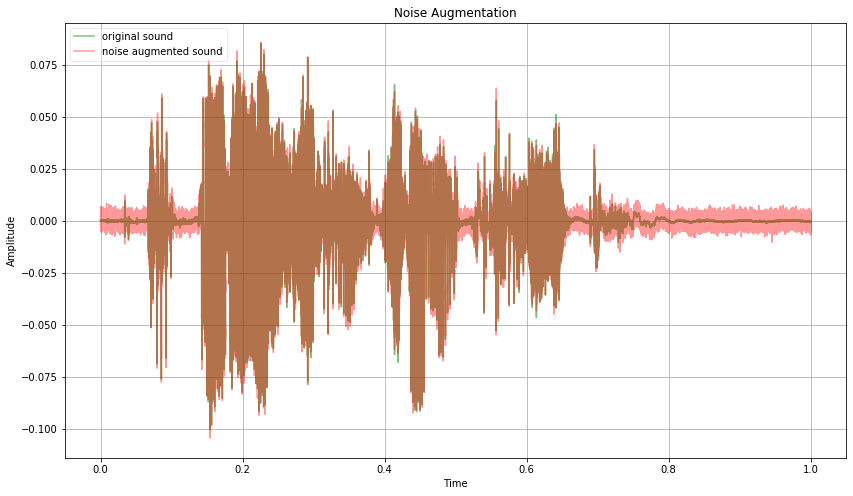

In [75]:
x2=noise(orig)
plot_time_series2(orig,x2,color='green',color1='red',label1='original sound',label2='noise augmented sound')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Noise Augmentation')
plt.savefig('Noise Augmentation')
plt.show()
ipd.Audio(orig, rate=sample_rate)

In [225]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load("C:/EmmotionCorrelation-master/ItalianData"+"/"+data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=11025,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]
        

 50%|████████████████████████████████████████▎                                       | 144/286 [00:05<00:05, 24.97it/s]


KeyboardInterrupt: 

In [163]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load("C:/EmmotionCorrelation-master/ItalianData"+"/"+data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=11025,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]
        

100%|████████████████████████████████████████████████████████████████████████████████| 286/286 [00:19<00:00, 14.35it/s]


In [164]:
len(syn_data1), len(syn_data2) 

(286, 286)

In [165]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [166]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

286

In [167]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-12.872974,-8.856770,-10.491532,-19.947753,-23.629142,-26.921380,-25.397004,-23.724733,-21.146701,-17.429365,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female_happy
1,-17.250500,-18.785429,-20.516610,-20.152061,-18.411904,-22.608878,-27.523203,-27.857626,-27.505625,-28.011440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female_happy
2,-15.398878,-15.642444,-19.101754,-17.928388,-16.106303,-19.240865,-20.982047,-22.796080,-25.524486,-28.658055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female_happy
3,-35.334004,-32.884659,-29.432879,-24.560819,-25.623838,-22.536713,-20.042015,-22.332518,-22.934652,-18.208831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female_happy
4,-31.900744,-19.684314,-9.826386,-7.947290,-13.641708,-15.306290,-11.516710,-11.376414,-18.559134,-21.967072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female_happy


In [168]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

286

In [169]:
syndf2.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-13.266830,-9.769478,-11.634345,-19.201053,-22.761358,-27.150626,-26.543671,-25.506881,-24.469796,-22.298389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female_happy
1,-18.310159,-20.197459,-22.239019,-21.381335,-22.464030,-25.481603,-29.773277,-32.678855,-32.828215,-30.869220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female_happy
2,-15.357554,-16.460969,-21.270406,-21.060512,-20.014529,-21.091211,-23.709547,-27.253139,-30.666918,-33.571591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female_happy
3,-40.901769,-39.327960,-34.124520,-28.831600,-26.669951,-23.625463,-21.747400,-23.095903,-21.051109,-13.785407,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female_happy
4,-27.301232,-21.191741,-18.603308,-17.019864,-15.556265,-17.257209,-17.465322,-16.262096,-17.068399,-21.025317,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,female_happy


In [170]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,label
0,-12.958727,-8.960438,-10.585801,-20.048144,-23.720495,-27.356837,-25.590474,-23.891646,-21.239610,-17.473833,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_happy
1,-17.196390,-18.817157,-20.658501,-20.354739,-18.558330,-22.859265,-27.986143,-28.161847,-27.824130,-28.110926,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_happy
2,-15.532286,-15.940167,-19.426382,-18.439185,-16.738193,-20.177370,-21.678285,-23.661842,-27.336681,-31.445938,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_happy
3,-41.203962,-40.670650,-33.072638,-25.494408,-26.686402,-23.083997,-20.470415,-22.859257,-23.496542,-18.668210,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_happy
4,-40.138501,-21.775403,-10.196636,-8.223827,-13.843441,-15.795876,-12.154737,-11.946839,-18.834485,-22.502770,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,female_happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,-8.714196,-11.638229,-16.229302,-16.688004,-14.234971,-12.339240,-14.878869,-15.545992,-15.338502,-16.273027,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_sad
854,-17.832921,-13.089135,-13.291181,-15.072281,-13.552985,-13.988327,-16.365411,-18.202351,-19.804718,-21.446883,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_sad
855,-12.078720,-14.827053,-17.414941,-15.200100,-16.359698,-19.070112,-14.415765,-13.171212,-15.584890,-18.989442,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_sad
856,-10.839019,-12.865336,-17.527815,-18.718365,-18.879526,-16.035244,-16.107704,-17.255904,-17.619401,-16.149077,...,-17.877261,-19.345943,-20.469881,-21.568025,-23.121619,-25.195280,-28.223138,-32.855715,-39.430302,male_sad


In [171]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [172]:
y_train.value_counts()

female_calm     101
female_happy    101
female_sad      101
female_angry    101
male_happy       81
male_angry       67
male_sad         67
male_calm        67
Name: label, dtype: int64

In [173]:
y_test.value_counts()

female_happy    25
female_angry    25
female_calm     25
female_sad      25
male_happy      21
male_sad        17
male_calm       17
male_angry      17
Name: label, dtype: int64

In [174]:
X_train.isna().sum().sum()

0

In [175]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [176]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [177]:
X_train.shape

(686, 65)

# VIII. Changing dimension for CNN model

In [184]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)


In [185]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr



In [186]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)


In [57]:
# Original Model

# model = Sequential()
# model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(5))
# model.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [187]:
# Plotting Model Summary

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 65, 256)           2304      
_________________________________________________________________
activation_10 (Activation)   (None, 65, 256)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 65, 256)           524544    
_________________________________________________________________
batch_normalization_3 (Batch (None, 65, 256)           1024      
_________________________________________________________________
activation_11 (Activation)   (None, 65, 256)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 65, 256)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 256)           

In [188]:
# Compile your model

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

# IX. Removed the whole training part for avoiding unnecessary long epochs list

In [60]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('aug_noiseNshift_2class2_np.h5_italian', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])


Train on 686 samples, validate on 172 samples
Epoch 1/700
686/686 [==============================] - 5s 8ms/step - loss: 2.0921 - accuracy: 0.1093 - fscore: 0.0000e+00 - val_loss: 2.0789 - val_accuracy: 0.1105 - val_fscore: 0.0000e+00
Epoch 2/700
686/686 [==============================] - 3s 5ms/step - loss: 2.0889 - accuracy: 0.1064 - fscore: 0.0000e+00 - val_loss: 2.0789 - val_accuracy: 0.1221 - val_fscore: 0.0000e+00
Epoch 3/700
686/686 [==============================] - 3s 4ms/step - loss: 2.0854 - accuracy: 0.1210 - fscore: 0.0000e+00 - val_loss: 2.0792 - val_accuracy: 0.1105 - val_fscore: 0.0000e+00
Epoch 4/700
686/686 [==============================] - 3s 4ms/step - loss: 2.0851 - accuracy: 0.1079 - fscore: 0.0000e+00 - val_loss: 2.0792 - val_accuracy: 0.1221 - val_fscore: 0.0000e+00
Epoch 5/700
686/686 [==============================] - 3s 5ms/step - loss: 2.0812 - accuracy: 0.1385 - fscore: 0.0000e+00 - val_loss: 2.0788 - val_accuracy: 0.1279 - val_fscore: 0.0000e+00
Epoch 6/

Epoch 43/700
686/686 [==============================] - 3s 5ms/step - loss: 2.0184 - accuracy: 0.2026 - fscore: 0.0000e+00 - val_loss: 2.0420 - val_accuracy: 0.1802 - val_fscore: 0.0000e+00
Epoch 44/700
686/686 [==============================] - 3s 5ms/step - loss: 2.0201 - accuracy: 0.2157 - fscore: 0.0000e+00 - val_loss: 2.0410 - val_accuracy: 0.1802 - val_fscore: 0.0000e+00
Epoch 45/700
686/686 [==============================] - 4s 6ms/step - loss: 2.0179 - accuracy: 0.2157 - fscore: 0.0000e+00 - val_loss: 2.0403 - val_accuracy: 0.1802 - val_fscore: 0.0000e+00
Epoch 46/700
686/686 [==============================] - 3s 4ms/step - loss: 2.0150 - accuracy: 0.2099 - fscore: 0.0000e+00 - val_loss: 2.0393 - val_accuracy: 0.1860 - val_fscore: 0.0000e+00
Epoch 47/700
686/686 [==============================] - 3s 5ms/step - loss: 2.0151 - accuracy: 0.2289 - fscore: 0.0000e+00 - val_loss: 2.0386 - val_accuracy: 0.1802 - val_fscore: 0.0000e+00
Epoch 48/700
686/686 [============================

686/686 [==============================] - 3s 5ms/step - loss: 1.9155 - accuracy: 0.2959 - fscore: 0.0000e+00 - val_loss: 1.9741 - val_accuracy: 0.2558 - val_fscore: 0.0000e+00
Epoch 130/700
686/686 [==============================] - 4s 6ms/step - loss: 1.9160 - accuracy: 0.3163 - fscore: 0.0000e+00 - val_loss: 1.9732 - val_accuracy: 0.2558 - val_fscore: 0.0000e+00
Epoch 131/700
686/686 [==============================] - 3s 5ms/step - loss: 1.9169 - accuracy: 0.3178 - fscore: 0.0000e+00 - val_loss: 1.9726 - val_accuracy: 0.2558 - val_fscore: 0.0000e+00
Epoch 132/700
686/686 [==============================] - 3s 5ms/step - loss: 1.9138 - accuracy: 0.2945 - fscore: 0.0000e+00 - val_loss: 1.9718 - val_accuracy: 0.2558 - val_fscore: 0.0000e+00
Epoch 133/700
686/686 [==============================] - 3s 4ms/step - loss: 1.9125 - accuracy: 0.3032 - fscore: 0.0000e+00 - val_loss: 1.9708 - val_accuracy: 0.2558 - val_fscore: 0.0000e+00
Epoch 134/700
686/686 [==============================] - 3s

Epoch 172/700
686/686 [==============================] - 3s 5ms/step - loss: 1.8585 - accuracy: 0.3382 - fscore: 0.0000e+00 - val_loss: 1.9361 - val_accuracy: 0.2791 - val_fscore: 0.0000e+00
Epoch 173/700
686/686 [==============================] - 4s 5ms/step - loss: 1.8664 - accuracy: 0.3324 - fscore: 0.0000e+00 - val_loss: 1.9353 - val_accuracy: 0.2791 - val_fscore: 0.0000e+00
Epoch 174/700
686/686 [==============================] - 3s 5ms/step - loss: 1.8541 - accuracy: 0.3324 - fscore: 0.0000e+00 - val_loss: 1.9349 - val_accuracy: 0.2791 - val_fscore: 0.0000e+00
Epoch 175/700
686/686 [==============================] - 3s 5ms/step - loss: 1.8575 - accuracy: 0.3324 - fscore: 0.0000e+00 - val_loss: 1.9345 - val_accuracy: 0.2849 - val_fscore: 0.0000e+00
Epoch 176/700
686/686 [==============================] - 3s 4ms/step - loss: 1.8569 - accuracy: 0.3571 - fscore: 0.0000e+00 - val_loss: 1.9337 - val_accuracy: 0.2849 - val_fscore: 0.0000e+00
Epoch 177/700
686/686 [======================

Epoch 215/700
686/686 [==============================] - 3s 4ms/step - loss: 1.7992 - accuracy: 0.3615 - fscore: 0.0000e+00 - val_loss: 1.8980 - val_accuracy: 0.3081 - val_fscore: 0.0000e+00
Epoch 216/700
686/686 [==============================] - 4s 6ms/step - loss: 1.7950 - accuracy: 0.3630 - fscore: 0.0000e+00 - val_loss: 1.8977 - val_accuracy: 0.3081 - val_fscore: 0.0000e+00
Epoch 217/700
686/686 [==============================] - 4s 6ms/step - loss: 1.7944 - accuracy: 0.3863 - fscore: 0.0000e+00 - val_loss: 1.8954 - val_accuracy: 0.3081 - val_fscore: 0.0000e+00
Epoch 218/700
686/686 [==============================] - 3s 4ms/step - loss: 1.7978 - accuracy: 0.3601 - fscore: 0.0000e+00 - val_loss: 1.8966 - val_accuracy: 0.3081 - val_fscore: 0.0000e+00
Epoch 219/700
686/686 [==============================] - 4s 5ms/step - loss: 1.7974 - accuracy: 0.3659 - fscore: 0.0000e+00 - val_loss: 1.8947 - val_accuracy: 0.3081 - val_fscore: 0.0000e+00
Epoch 220/700
686/686 [======================

686/686 [==============================] - 3s 5ms/step - loss: 1.6432 - accuracy: 0.4577 - fscore: 0.0000e+00 - val_loss: 1.8068 - val_accuracy: 0.3779 - val_fscore: 0.0000e+00
Epoch 301/700
686/686 [==============================] - 3s 5ms/step - loss: 1.6459 - accuracy: 0.4606 - fscore: 0.0000e+00 - val_loss: 1.8045 - val_accuracy: 0.3663 - val_fscore: 0.0000e+00
Epoch 302/700
686/686 [==============================] - 3s 4ms/step - loss: 1.6441 - accuracy: 0.4373 - fscore: 0.0000e+00 - val_loss: 1.7991 - val_accuracy: 0.3837 - val_fscore: 0.0000e+00
Epoch 303/700
686/686 [==============================] - 4s 5ms/step - loss: 1.6401 - accuracy: 0.4446 - fscore: 0.0000e+00 - val_loss: 1.7975 - val_accuracy: 0.3779 - val_fscore: 0.0000e+00
Epoch 304/700
686/686 [==============================] - 3s 5ms/step - loss: 1.6405 - accuracy: 0.4344 - fscore: 0.0027 - val_loss: 1.8001 - val_accuracy: 0.3779 - val_fscore: 0.0000e+00
Epoch 305/700
686/686 [==============================] - 4s 5ms

Epoch 344/700
686/686 [==============================] - 3s 5ms/step - loss: 1.5550 - accuracy: 0.4913 - fscore: 0.0217 - val_loss: 1.7456 - val_accuracy: 0.3895 - val_fscore: 0.0000e+00
Epoch 345/700
686/686 [==============================] - 3s 5ms/step - loss: 1.5394 - accuracy: 0.5087 - fscore: 0.0243 - val_loss: 1.7530 - val_accuracy: 0.3837 - val_fscore: 0.0000e+00
Epoch 346/700
686/686 [==============================] - 4s 7ms/step - loss: 1.5499 - accuracy: 0.4927 - fscore: 0.0219 - val_loss: 1.7544 - val_accuracy: 0.3605 - val_fscore: 0.0000e+00
Epoch 347/700
686/686 [==============================] - 4s 6ms/step - loss: 1.5395 - accuracy: 0.4913 - fscore: 0.0353 - val_loss: 1.7422 - val_accuracy: 0.3895 - val_fscore: 0.0000e+00
Epoch 348/700
686/686 [==============================] - 3s 5ms/step - loss: 1.5483 - accuracy: 0.4971 - fscore: 0.0374 - val_loss: 1.7391 - val_accuracy: 0.4070 - val_fscore: 0.0000e+00
Epoch 349/700
686/686 [==============================] - 4s 5ms/s

Epoch 388/700
686/686 [==============================] - 3s 4ms/step - loss: 1.4574 - accuracy: 0.5525 - fscore: 0.0954 - val_loss: 1.6859 - val_accuracy: 0.4360 - val_fscore: 0.0000e+00
Epoch 389/700
686/686 [==============================] - 4s 6ms/step - loss: 1.4381 - accuracy: 0.5510 - fscore: 0.0793 - val_loss: 1.6892 - val_accuracy: 0.4244 - val_fscore: 0.0107
Epoch 390/700
686/686 [==============================] - 4s 6ms/step - loss: 1.4494 - accuracy: 0.5379 - fscore: 0.0835 - val_loss: 1.6839 - val_accuracy: 0.4302 - val_fscore: 0.0000e+00
Epoch 391/700
686/686 [==============================] - 4s 5ms/step - loss: 1.4626 - accuracy: 0.5087 - fscore: 0.0859 - val_loss: 1.6759 - val_accuracy: 0.4477 - val_fscore: 0.0000e+00
Epoch 392/700
686/686 [==============================] - 3s 5ms/step - loss: 1.4378 - accuracy: 0.5554 - fscore: 0.1100 - val_loss: 1.6646 - val_accuracy: 0.4651 - val_fscore: 0.0107
Epoch 393/700
686/686 [==============================] - 3s 4ms/step - lo

Epoch 433/700
686/686 [==============================] - 4s 5ms/step - loss: 1.3503 - accuracy: 0.6093 - fscore: 0.1351 - val_loss: 1.6264 - val_accuracy: 0.5000 - val_fscore: 0.0428
Epoch 434/700
686/686 [==============================] - 3s 5ms/step - loss: 1.3475 - accuracy: 0.6020 - fscore: 0.1608 - val_loss: 1.6155 - val_accuracy: 0.5116 - val_fscore: 0.0535
Epoch 435/700
686/686 [==============================] - 3s 4ms/step - loss: 1.3474 - accuracy: 0.6020 - fscore: 0.1523 - val_loss: 1.5904 - val_accuracy: 0.5174 - val_fscore: 0.0535
Epoch 436/700
686/686 [==============================] - 3s 5ms/step - loss: 1.3213 - accuracy: 0.6064 - fscore: 0.1806 - val_loss: 1.6141 - val_accuracy: 0.5058 - val_fscore: 0.0535
Epoch 437/700
686/686 [==============================] - 3s 4ms/step - loss: 1.3400 - accuracy: 0.6122 - fscore: 0.1514 - val_loss: 1.5942 - val_accuracy: 0.5233 - val_fscore: 0.0535
Epoch 438/700
686/686 [==============================] - 3s 5ms/step - loss: 1.3270 -

Epoch 478/700
686/686 [==============================] - 4s 5ms/step - loss: 1.2105 - accuracy: 0.6545 - fscore: 0.2376 - val_loss: 1.5103 - val_accuracy: 0.5930 - val_fscore: 0.0725
Epoch 479/700
686/686 [==============================] - 4s 6ms/step - loss: 1.2076 - accuracy: 0.6837 - fscore: 0.2406 - val_loss: 1.5474 - val_accuracy: 0.5581 - val_fscore: 0.0725
Epoch 480/700
686/686 [==============================] - 3s 5ms/step - loss: 1.1986 - accuracy: 0.6837 - fscore: 0.2730 - val_loss: 1.5105 - val_accuracy: 0.5814 - val_fscore: 0.0725
Epoch 481/700
686/686 [==============================] - 4s 6ms/step - loss: 1.2185 - accuracy: 0.6764 - fscore: 0.2394 - val_loss: 1.5782 - val_accuracy: 0.4884 - val_fscore: 0.0832
Epoch 482/700
686/686 [==============================] - 3s 4ms/step - loss: 1.2101 - accuracy: 0.6662 - fscore: 0.2389 - val_loss: 1.5591 - val_accuracy: 0.5116 - val_fscore: 0.0832
Epoch 483/700
686/686 [==============================] - 4s 6ms/step - loss: 1.1990 -

Epoch 567/700
686/686 [==============================] - 4s 5ms/step - loss: 0.9796 - accuracy: 0.7493 - fscore: 0.4613 - val_loss: 1.3662 - val_accuracy: 0.5988 - val_fscore: 0.2100
Epoch 568/700
686/686 [==============================] - 4s 5ms/step - loss: 0.9679 - accuracy: 0.7536 - fscore: 0.4869 - val_loss: 1.3707 - val_accuracy: 0.5930 - val_fscore: 0.2234
Epoch 569/700
686/686 [==============================] - 3s 4ms/step - loss: 0.9730 - accuracy: 0.7566 - fscore: 0.4821 - val_loss: 1.3468 - val_accuracy: 0.6512 - val_fscore: 0.2255
Epoch 570/700
686/686 [==============================] - 3s 4ms/step - loss: 0.9561 - accuracy: 0.7770 - fscore: 0.5039 - val_loss: 1.3708 - val_accuracy: 0.5814 - val_fscore: 0.1903
Epoch 571/700
686/686 [==============================] - 3s 5ms/step - loss: 0.9529 - accuracy: 0.7609 - fscore: 0.5092 - val_loss: 1.4060 - val_accuracy: 0.5291 - val_fscore: 0.1933
Epoch 572/700
686/686 [==============================] - 4s 5ms/step - loss: 0.9841 -

Epoch 656/700
686/686 [==============================] - 3s 5ms/step - loss: 0.7304 - accuracy: 0.8426 - fscore: 0.7081 - val_loss: 1.2170 - val_accuracy: 0.6279 - val_fscore: 0.3527
Epoch 657/700
686/686 [==============================] - 3s 5ms/step - loss: 0.7563 - accuracy: 0.8280 - fscore: 0.6795 - val_loss: 1.1836 - val_accuracy: 0.6512 - val_fscore: 0.3581
Epoch 658/700
686/686 [==============================] - 3s 4ms/step - loss: 0.7375 - accuracy: 0.8411 - fscore: 0.6827 - val_loss: 1.1268 - val_accuracy: 0.6860 - val_fscore: 0.3458
Epoch 659/700
686/686 [==============================] - 3s 5ms/step - loss: 0.7371 - accuracy: 0.8382 - fscore: 0.6961 - val_loss: 1.2196 - val_accuracy: 0.6337 - val_fscore: 0.3460
Epoch 660/700
686/686 [==============================] - 4s 5ms/step - loss: 0.7312 - accuracy: 0.8484 - fscore: 0.7006 - val_loss: 1.1731 - val_accuracy: 0.6512 - val_fscore: 0.3598
Epoch 661/700
686/686 [==============================] - 3s 4ms/step - loss: 0.7210 -

In [ ]:
# Plotting the Train Valid Loss Graph
loaded_model.load_weights("aug_noiseNshift_2class2_np_italian.h5")
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

## Saving the model

In [62]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [194]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 14.53%


# X. Predicting emotions on the test data

In [104]:
feeling_list_french=[]
work_dir_french='C:/EmmotionCorrelation-master/French'
my_list_french=os.listdir(work_dir_french)


In [105]:
feeling_list_french=[]
for item in my_list_french:
    if item[3:4]=='C' and int(item[0:2])%2==0:
        feeling_list_french.append('female_angry')
    elif item[3:4]=='C' and int(item[0:2])%2==1:
        feeling_list_french.append('male_angry')
    
    if item[3:4]=='D' and int(item[0:2])%2==0:
        feeling_list_french.append('female_disgust')
    elif item[3:4]=='D' and int(item[0:2])%2==1:
        feeling_list_french.append('male_disgust')
     
    if item[3:4]=='J' and int(item[0:2])%2==0:
        feeling_list_french.append('female_happy')
    elif item[3:4]=='J' and int(item[0:2])%2==1:
        feeling_list_french.append('male_happy')
    
    
    if item[3:4]=='N' and int(item[0:2])%2==0:
        feeling_list_french.append('female_calm')
    elif item[3:4]=='N' and int(item[0:2])%2==1:
        feeling_list_french.append('male_calm')
    
    if item[3:4]=='P' and int(item[0:2])%2==0:
        feeling_list_french.append('female_fear')
    elif item[3:4]=='P' and int(item[0:2])%2==1:
        feeling_list_french.append('male_fear')
    
    if item[3:4]=='S' and int(item[0:2])%2==0:
        feeling_list_french.append('female_surprise')
    elif item[3:4]=='S' and int(item[0:2])%2==1:
        feeling_list_french.append('male_surprise')
        
    if item[3:4]=='T' and int(item[0:2])%2==0:
        feeling_list_french.append('female_sad')
    elif item[3:4]=='T' and int(item[0:2])%2==1:
        feeling_list_french.append('male_sad')
feeling_list_french=np.array(feeling_list_french)

In [112]:
my_list_french=pd.Series(my_list_french,name='filename')
feeling_list_french=pd.Series(feeling_list_french,name='feeling')
french=pd.concat([my_list_french,feeling_list_french],axis=1)
french
#calm
#happy
#sad
#angry
french.filename[2]

'01-D-2-1.wav'

In [114]:
french=french[french.feeling!='male_disgust']
french=french[french.feeling!='female_disgust']
french=french[french.feeling!='male_surprise']
french=french[french.feeling!='male_fear']
french=french[french.feeling!='female_surprise']
french=french[french.feeling!='female_fear']
french=french.reset_index()
data_test = pd.DataFrame(columns=['feature'])

for i in range(len(french)):
    X, sample_rate = librosa.load(work_dir_french+'/'+french.filename[i], res_type='kaiser_fast',duration=input_duration,sr=11025,offset=0.5)
#     X = X[10000:90000]
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(french.feeling)
test_valid_lb


array(['male_angry', 'male_angry', 'male_happy', 'male_happy',
       'male_calm', 'male_calm', 'male_sad', 'male_sad', 'female_angry',
       'female_angry', 'female_happy', 'female_happy', 'female_calm',
       'female_calm', 'female_sad', 'female_sad', 'male_angry',
       'male_angry', 'male_happy', 'male_happy', 'male_calm', 'male_calm',
       'male_sad', 'male_sad', 'female_angry', 'female_angry',
       'female_happy', 'female_happy', 'female_calm', 'female_calm',
       'female_sad', 'female_sad', 'male_angry', 'male_angry',
       'male_happy', 'male_happy', 'male_calm', 'male_calm', 'male_sad',
       'male_sad', 'female_angry', 'female_angry', 'female_happy',
       'female_happy', 'female_calm', 'female_calm', 'female_sad',
       'female_sad'], dtype=object)

In [115]:
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

In [116]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

48/48 [==============================] - 0s 5ms/step


In [117]:
preds

array([[7.24437609e-02, 3.71873379e-01, 3.51563916e-02, 9.41767618e-02,
        1.72229037e-02, 4.47345944e-03, 2.04717112e-03, 4.02606159e-01],
       [1.77447096e-01, 6.18967175e-01, 2.54974756e-02, 6.97693750e-02,
        9.49908234e-03, 2.83353240e-03, 1.13171176e-03, 9.48546082e-02],
       [2.25406438e-02, 1.51631579e-01, 1.67568579e-01, 6.56187594e-01,
        1.09760018e-04, 1.33050241e-06, 3.39965554e-05, 1.92656880e-03],
       [1.10693658e-02, 2.98766028e-02, 3.46637778e-02, 8.84515345e-01,
        3.17523009e-05, 3.86503780e-05, 6.33408723e-04, 3.91711444e-02],
       [5.77989146e-02, 1.04677965e-04, 1.58742059e-03, 2.46517430e-03,
        6.29782025e-03, 1.53751737e-02, 8.46874237e-01, 6.94965646e-02],
       [1.99179724e-01, 3.31936739e-02, 2.56269146e-02, 6.18477948e-02,
        4.32316251e-02, 6.02902807e-02, 1.53091758e-01, 4.23538297e-01],
       [3.73536319e-01, 4.34062304e-03, 5.32871664e-01, 6.91665486e-02,
        2.33976590e-03, 1.83134798e-05, 7.12372130e-03, 1.

In [118]:
preds1=preds.argmax(axis=1)

In [119]:
preds1

array([7, 1, 3, 3, 6, 7, 2, 7, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 7, 1, 7, 4,
       3, 0, 3, 3, 3, 3, 1, 1, 1, 3, 0, 7, 7, 3, 0, 0, 3, 3, 3, 3, 3, 1,
       1, 3, 3, 1], dtype=int64)

In [120]:
abc = preds1.astype(int).flatten()

In [121]:
predictions = (lb.inverse_transform((abc)))

In [122]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_sad
1,female_calm
2,female_sad
3,female_sad
4,male_happy
5,male_sad
6,female_happy
7,male_sad
8,female_sad
9,female_sad


In [123]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [124]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_angry
1,male_angry
2,male_happy
3,male_happy
4,male_calm
5,male_calm
6,male_sad
7,male_sad
8,female_angry
9,female_angry


In [125]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [127]:
finaldf

,actualvalues,predictedvalues
0,male_angry,male_sad
1,male_angry,female_calm
2,male_happy,female_sad
3,male_happy,female_sad
4,male_calm,male_happy
5,male_calm,male_sad
6,male_sad,female_happy
7,male_sad,male_sad
8,female_angry,female_sad
9,female_angry,female_sad


In [128]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,6
female_calm,6
female_happy,6
female_sad,6
male_angry,6
male_calm,6
male_happy,6
male_sad,6


In [129]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,4
female_calm,12
female_happy,1
female_sad,22
male_angry,1
male_happy,1
male_sad,7


In [130]:
finaldf.to_csv('Predictions.csv', index=False)

In [115]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [116]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

NameError: name 'finaldf' is not defined

In [133]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

10.157203907203908

In [134]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[0, 0, 0, 6, 0, 0, 0, 0],
       [0, 4, 0, 2, 0, 0, 0, 0],
       [0, 1, 0, 5, 0, 0, 0, 0],
       [0, 3, 0, 3, 0, 0, 0, 0],
       [1, 3, 0, 0, 0, 0, 0, 2],
       [2, 0, 0, 0, 1, 0, 1, 2],
       [0, 1, 0, 3, 0, 0, 0, 2],
       [1, 0, 1, 3, 0, 0, 0, 1]], dtype=int64)

In [114]:
# Visualize Confusion Matrix 

# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
#class_names = ['male_negative', 'male_positive']
class_names = ['female_angry', 'female_calm', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)

NameError: name 'print_confusion_matrix' is not defined

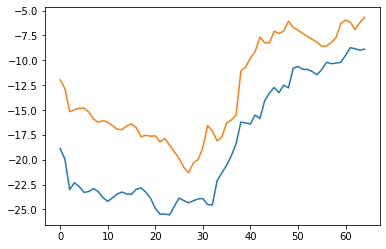

In [124]:
combined_df[combined_df.label=='female_happy'].mean().plot()


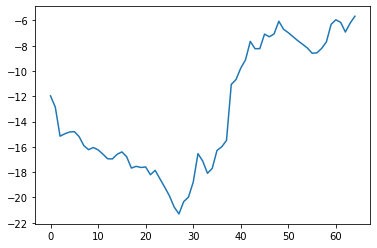

In [108]:
combined_df[combined_df.label=='male_happy'].mean().plot()


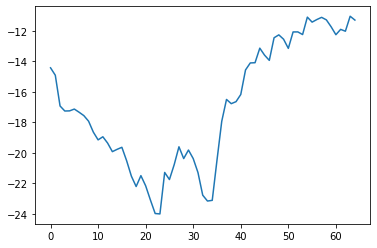

In [113]:
combined_df[combined_df.label=='male_sad'].mean().plot()


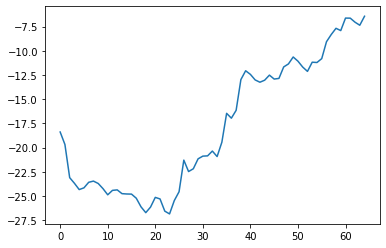

In [109]:
combined_df[combined_df.label=='female_angry'].mean().plot()


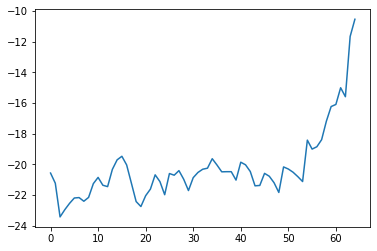

In [110]:
combined_df[combined_df.label=='male_angry'].mean().plot()


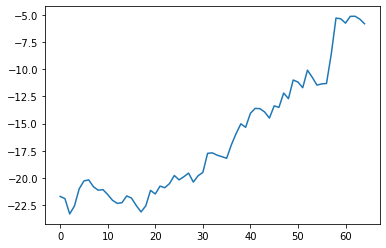

In [111]:
combined_df[combined_df.label=='female_calm'].mean().plot()


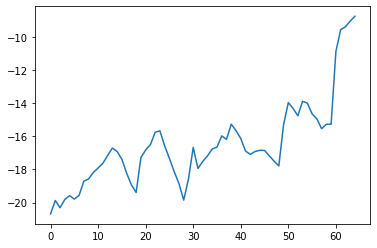

In [112]:
combined_df[combined_df.label=='male_calm'].mean().plot()


In [126]:
combined_df.to_csv("Italiandatasheet.csv",index=False)